

## Introduction

In this notebook, we tackle a **DNA sequence classification** task: predicting the **type of gene** (e.g., *PSEUDO*, *BIOLOGICAL\_REGION*) based on its **nucleotide sequence**.

The dataset contains gene entries with their NCBI ID, symbol, description, gene type (our target label), and raw DNA sequences. Our main objective is to explore whether machine learning models can learn meaningful patterns in the sequences to classify gene types accurately.

We’ll start by preprocessing the sequences using **k-mer encoding**, then train and evaluate classification models such as Random Forests. This project demonstrates a practical application of machine learning in bioinformatics — bridging the gap between raw DNA data and functional gene annotation.


#### Tools

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import hstack

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


## EDA

In [2]:
df = pd.read_csv('/kaggle/input/dna-sequence-prediction/train.csv')

In [3]:
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

Filter out the unnecessary chars from NucleotideSequence.

In [4]:
df['NucleotideSequence'] = df['NucleotideSequence'].str.replace(r'[<>]', '', regex=True)

In [5]:
df

,NCBIGeneID,Symbol,Description,GeneType,GeneGroupMethod,NucleotideSequence
0,106481178,RNU4-21P,"RNA, U4 small nuclear 21, pseudogene",PSEUDO,NCBI Ortholog,AGCTTAGCACAGTGGCAGTATCATAGGCAGTGAGGTTTATCCGAGG...
1,123477792,LOC123477792,Sharpr-MPRA regulatory region 12926,BIOLOGICAL_REGION,NCBI Ortholog,CTGGAGCGGCCACGATGTGAACTGTCACCGGCCACTGCTGCTCCGA...
2,113174975,LOC113174975,Sharpr-MPRA regulatory region 7591,BIOLOGICAL_REGION,NCBI Ortholog,TTCCCAATTTTTCCTCTGCTTTTTAATTTTCTAGTTTCCTTTTTCC...
3,116216107,LOC116216107,CRISPRi-validated cis-regulatory element chr10...,BIOLOGICAL_REGION,NCBI Ortholog,CGCCCAGGCTGGAGTGCAGTGGCGCCATCTCGGCTCACTGCAGGCT...
4,28502,IGHD2-21,immunoglobulin heavy diversity 2-21,OTHER,NCBI Ortholog,AGCATATTGTGGTGGTGACTGCTATTCC
...,...,...,...,...,...,...
22588,124907055,LOC124907055,uncharacterized LOC124907055,ncRNA,NCBI Ortholog,GGTGGGGTGGGGTGGGGTGGGGTGGGGTGCAGAGAAAACGATTGAT...
22589,106480032,RNU6-1060P,"RNA, U6 small nuclear 1060, pseudogene",PSEUDO,NCBI Ortholog,GTGCTCACTTCAGCAGCACATATACTAAAATTGGAATGATACAGAG...
22590,106481029,RN7SL387P,"RNA, 7SL, cytoplasmic 387, pseudogene",PSEUDO,NCBI Ortholog,GCTGGGCGTGGTGGTGGGTGCCTGTAATCCCAGCTACTAGGGAGGC...
22591,100286918,NDUFS5P2,NADH:ubiquinone oxidoreductase subunit S5 pseu...,PSEUDO,NCBI Ortholog,TCGTCCTGAAGCAGCGGCCAGAGAAGAGACAAGGGCACGAGCATCA...


Add seq len to the dataset, we may need it later

In [6]:
df['SequenceLength'] = df['NucleotideSequence'].str.len()

In [7]:
sns.set(style="whitegrid")

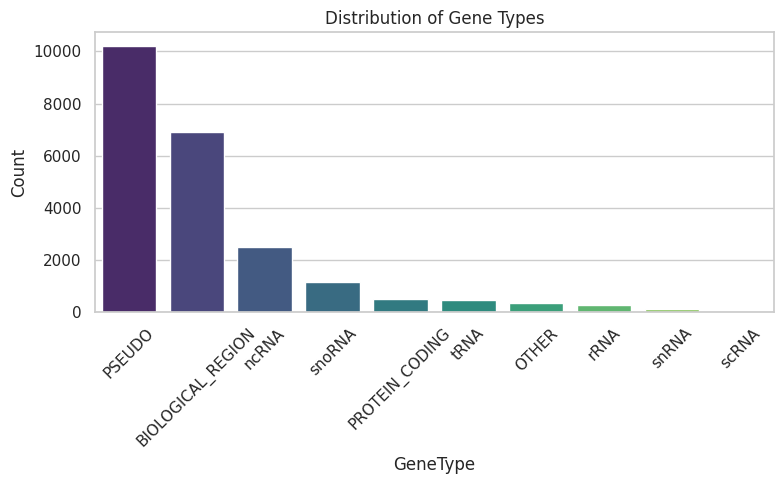

In [8]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='GeneType', palette='viridis', order=df['GeneType'].value_counts().index)
plt.title("Distribution of Gene Types")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

As we see, there is severe data imbalances in the dataset, so we will use metric like f1-score as our main metric.

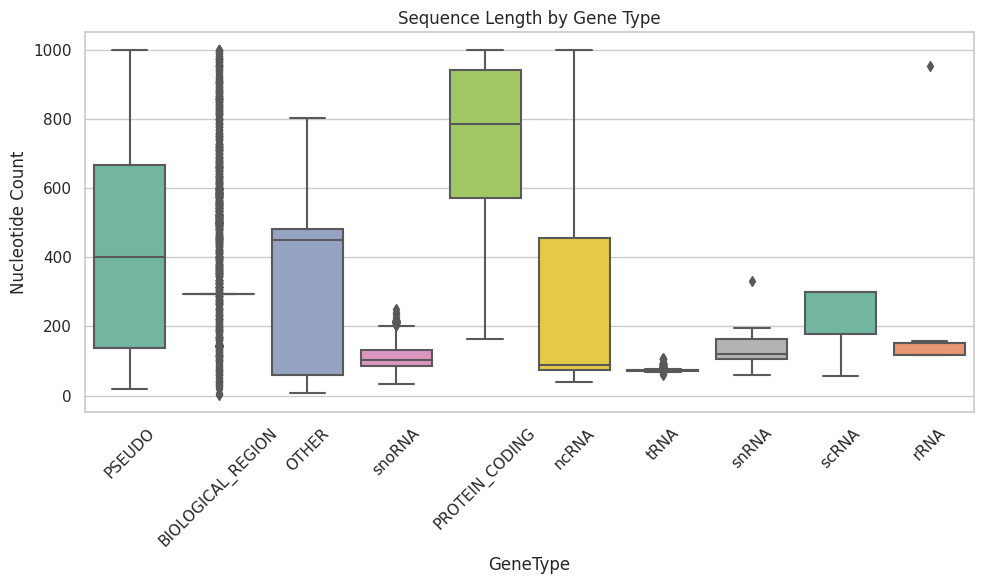

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='GeneType', y='SequenceLength', palette='Set2')
plt.title("Sequence Length by Gene Type")
plt.ylabel("Nucleotide Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 📌 Brief Insights:

* **Protein-coding genes** have the **longest sequences**, reflecting their complex structure.
* **Pseudogenes** also show **long and variable** sequence lengths.
* **Small RNAs** (`tRNA`, `snoRNA`, `snRNA`, etc.) have **short, tightly clustered** lengths.
* **Biological regions** show **high variability**, likely due to mixed functional elements.
* **ncRNA** and **OTHER** gene types have **diverse lengths**, suggesting heterogeneous content.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


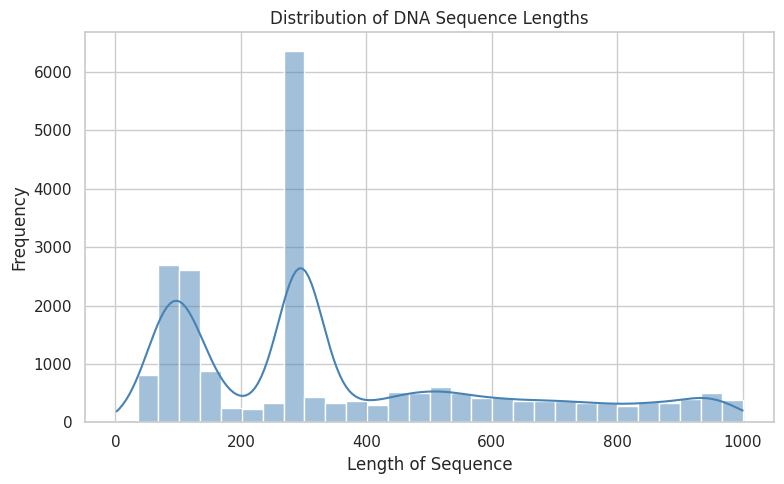

In [10]:
plt.figure(figsize=(8, 5))
sns.histplot(df['SequenceLength'], bins=30, kde=True, color='steelblue')
plt.title("Distribution of DNA Sequence Lengths")
plt.xlabel("Length of Sequence")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### 📌 Brief Insights:

* DNA sequence lengths show a **multi-modal distribution**.
* Peaks occur around **100–150 bp**, **\~275 bp**, and **500–600 bp**.
* A large spike near **275 bp** suggests a common sequence length, possibly from small RNA or specific gene types.
* Longer sequences (>600 bp) are less frequent but still present, likely corresponding to **protein-coding genes** or **pseudogenes**.


## Data preprocessing

Label encode the GeneType column (target Column)

In [11]:
le = LabelEncoder()
df['GeneType'] = le.fit_transform(df['GeneType'])


Convert the NucleotideSequence into a valid trainble column. we will convert the the NucleotideSequence into sub-sequences and then use CountVectorizer to convert it into valid trainable column. 

In [12]:
def get_kmers(sequence, size=3):
    return ' '.join([sequence[i:i+size] for i in range(len(sequence) - size + 1)])

Example

In [13]:
get_kmers('ASSRBERVADGBGTTTEWWQQEEEEEE')

'ASS SSR SRB RBE BER ERV RVA VAD ADG DGB GBG BGT GTT TTT TTE TEW EWW WWQ WQQ QQE QEE EEE EEE EEE EEE'

In [14]:
df['Kmers'] = df['NucleotideSequence'].apply(get_kmers)

In [15]:
df['Kmers']

0        AGC GCT CTT TTA TAG AGC GCA CAC ACA CAG AGT GT...
1        CTG TGG GGA GAG AGC GCG CGG GGC GCC CCA CAC AC...
2        TTC TCC CCC CCA CAA AAT ATT TTT TTT TTT TTC TC...
3        CGC GCC CCC CCA CAG AGG GGC GCT CTG TGG GGA GA...
4        AGC GCA CAT ATA TAT ATT TTG TGT GTG TGG GGT GT...
                               ...                        
22588    GGT GTG TGG GGG GGG GGT GTG TGG GGG GGG GGT GT...
22589    GTG TGC GCT CTC TCA CAC ACT CTT TTC TCA CAG AG...
22590    GCT CTG TGG GGG GGC GCG CGT GTG TGG GGT GTG TG...
22591    TCG CGT GTC TCC CCT CTG TGA GAA AAG AGC GCA CA...
22592    GGG GGG GGA GAT ATG TGT GTA TAG AGC GCT CTC TC...
Name: Kmers, Length: 22593, dtype: object

In [16]:
vectorizer = CountVectorizer()
X_kmers = vectorizer.fit_transform(df['Kmers'])

In [17]:
tfidf = TfidfVectorizer(max_features=100)
X_desc = tfidf.fit_transform(df['Description'])

One Hot Encode the GeneGroupMethod column.

In [18]:
ohe = OneHotEncoder()
X_method = ohe.fit_transform(df[['GeneGroupMethod']])


Stack the columns together using hstack (horizantal stack)

In [19]:
X_final = hstack([
    X_kmers,
    X_method,
    X_desc,
    df[['SequenceLength']]
])


y = df['GeneType']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)


## Model Selection

Test different models and select the best model.

In [21]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

In [22]:
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds, average='macro'),
        "Recall": recall_score(y_test, preds, average='macro'),
        "F1 Score": f1_score(y_test, preds, average='macro')
    })


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

In [23]:
results

[{'Model': 'Logistic Regression',
  'Accuracy': 0.9245408276167294,
  'Precision': 0.7402177896311077,
  'Recall': 0.6656989105521498,
  'F1 Score': 0.6881335572660581},
 {'Model': 'Random Forest',
  'Accuracy': 0.9800840894003098,
  'Precision': 0.9632950847128168,
  'Recall': 0.9504534475240624,
  'F1 Score': 0.955137149647207},
 {'Model': 'SVM',
  'Accuracy': 0.6552334587298074,
  'Precision': 0.18406328298134816,
  'Recall': 0.20863958079992492,
  'F1 Score': 0.19543313683143937},
 {'Model': 'Naive Bayes',
  'Accuracy': 0.7178579331710555,
  'Precision': 0.48576183937305883,
  'Recall': 0.6833238851732897,
  'F1 Score': 0.5197836615857548},
 {'Model': 'KNN',
  'Accuracy': 0.8404514273069263,
  'Precision': 0.7178343401858773,
  'Recall': 0.6742084304936032,
  'F1 Score': 0.6883337090061303},
 {'Model': 'Gradient Boosting',
  'Accuracy': 0.9836246957291436,
  'Precision': 0.9601370440611611,
  'Recall': 0.9749661935435503,
  'F1 Score': 0.9669105173198002},
 {'Model': 'Decision Tree

In [24]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="F1 Score", ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
results_df


,Model,Accuracy,Precision,Recall,F1 Score
0,Gradient Boosting,0.983625,0.960137,0.974966,0.966911
1,Random Forest,0.980084,0.963295,0.950453,0.955137
2,Decision Tree,0.978535,0.950967,0.955858,0.952580
3,KNN,0.840451,0.717834,0.674208,0.688334
4,Logistic Regression,0.924541,0.740218,0.665699,0.688134
5,Naive Bayes,0.717858,0.485762,0.683324,0.519784
6,SVM,0.655233,0.184063,0.208640,0.195433


As we can see, the GradientBoostingClassifier performs so good on the data, so we will stick with it.

## Model Training

In [25]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

GradientBoostingClassifier()

## Model Testing

In [26]:
y_pred = gb_model.predict(X_test)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
cm = confusion_matrix(y_test, y_pred)


In [27]:
print("Gradient Boosting Classifier Performance:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

Gradient Boosting Classifier Performance:
Accuracy : 0.9832
Precision: 0.9590
Recall   : 0.9702
F1 Score : 0.9641


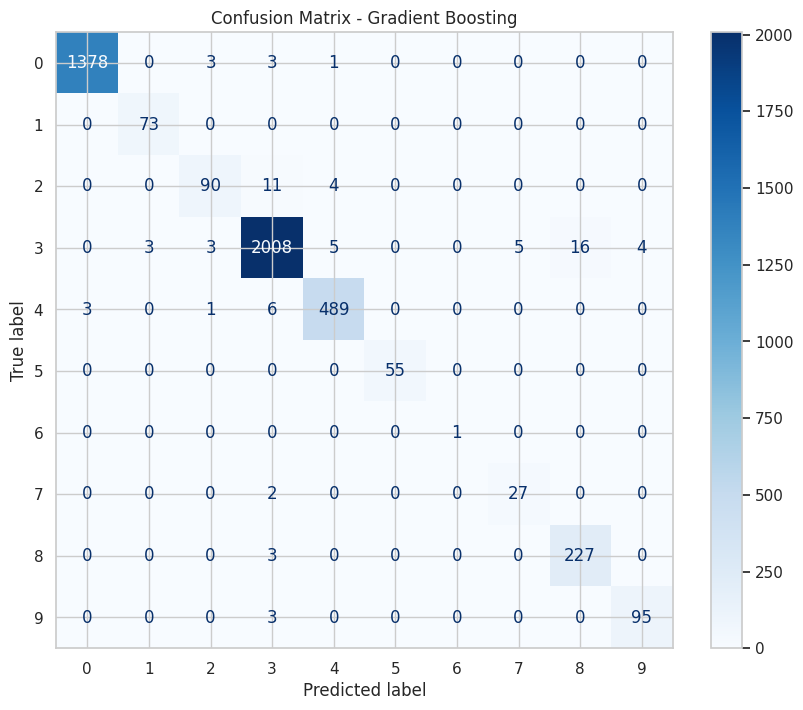

In [28]:
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gb_model.classes_)
disp.plot(cmap="Blues", ax=plt.gca())
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()


## Save The Model

In [29]:
import joblib
joblib.dump(gb_model, 'gradient_boosting_model.pkl')

['gradient_boosting_model.pkl']

## Thank You